## Import libs

In [4]:
from __future__ import print_function, division, absolute_import
import os
import GPy
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import math
import pandas as pd
from scipy.ndimage import gaussian_filter1d
from scipy import signal
import sys
sys.path.insert(0,'../..')
print(sys.path)
from mtfunc.helper import *
import safeopt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib as mpl
import tqdm
# plt.style.use('science')


['../..', '/Users/adrianpaeckelripoll/rbc-parameter-tuning/fig_scripts/optimizer_eval', '/opt/anaconda3/envs/env1/lib/python39.zip', '/opt/anaconda3/envs/env1/lib/python3.9', '/opt/anaconda3/envs/env1/lib/python3.9/lib-dynload', '', '/opt/anaconda3/envs/env1/lib/python3.9/site-packages', '/opt/anaconda3/envs/env1/lib/python3.9/site-packages/IPython/extensions', '/Users/adrianpaeckelripoll/.ipython']
/Users/adrianpaeckelripoll/rbc-parameter-tuning/mtfunc   was appended to PYTHONPATH


In [5]:
rnd_opt_cst=get_data('NL_opt/mrnd_opt_cst_winter_3_1_2_2022_03_15_0536.npy')
rnd_opt_par=get_data('NL_opt/mrnd_opt_par_winter_3_1_2_2022_03_15_0536.npy')
# violations=get_data('violations/winter0536_violations.npy')
violations=[]
rnd_opt_cst=np.delete(rnd_opt_cst,violations,axis=0)
rnd_opt_par=np.delete(rnd_opt_par,violations,axis=0)


# Evaluation 

2
2
0.5
1
2
1
0.5
0.5
2
1
1
0.5
False
['2', '0.5', '1', '2', '2', '0.5', '1', '2', '0.5', '1', '0.5', '1']
[2.0, 0.5, 1.0, 2.0, 2.0, 0.5, 1.0, 2.0, 0.5, 1.0, 0.5, 1.0]
False
beta: 0.5 par_num 1


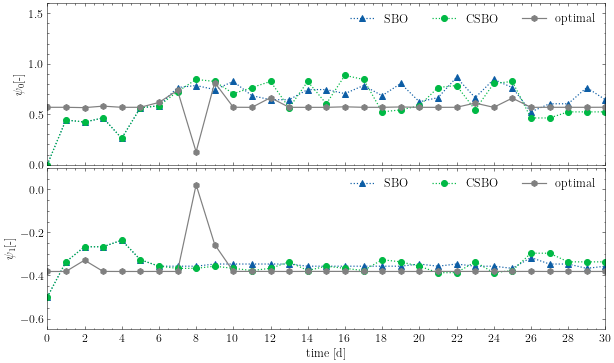

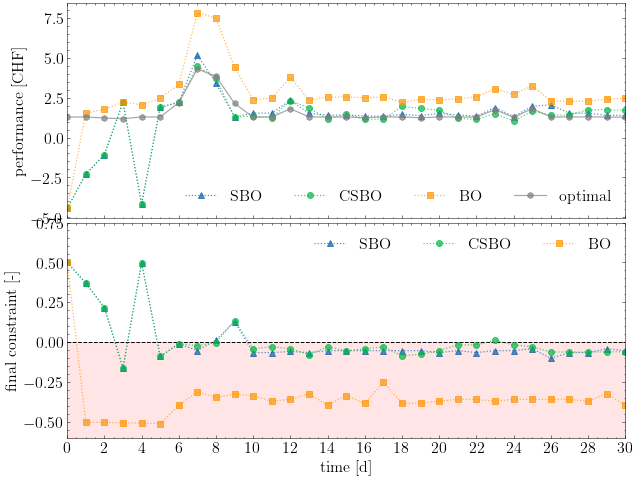

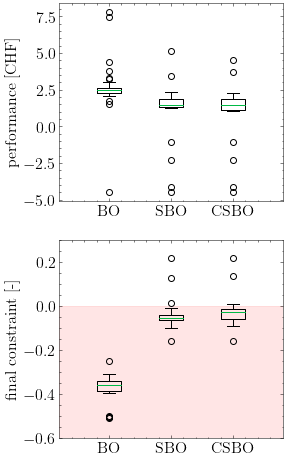

beta: 1 par_num 1


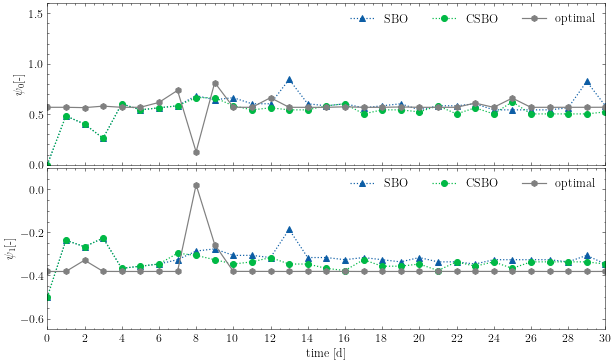

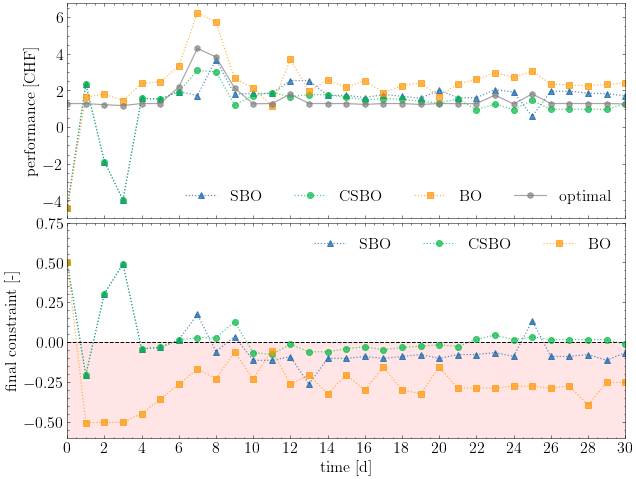

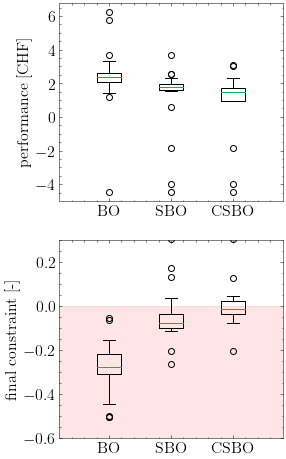

beta: 2 par_num 1


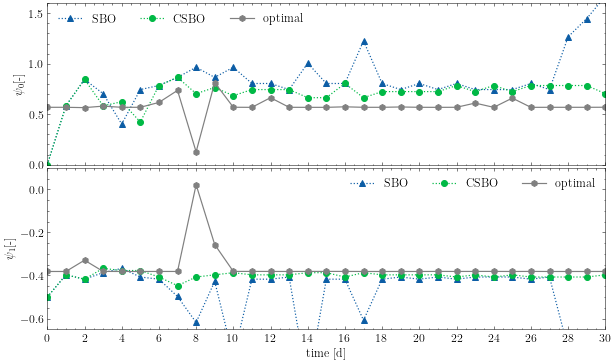

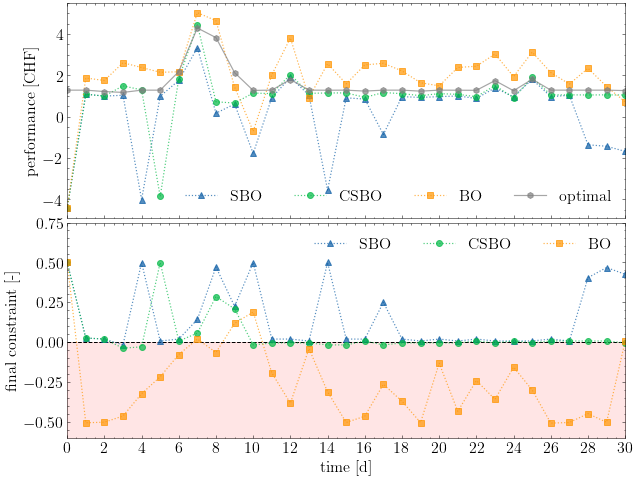

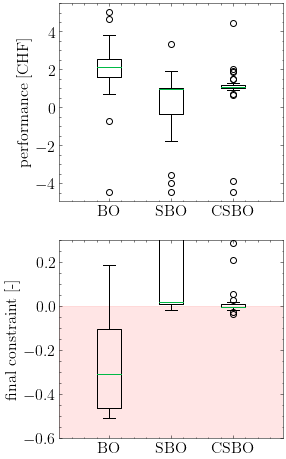

1
1
2
1
2
1
0.5
0.5
0.5
2
0.5
2
False
['2', '1', '0.5', '1', '0.5', '1', '0.5', '0.5', '2', '1', '2', '2']
[2.0, 1.0, 0.5, 1.0, 0.5, 1.0, 0.5, 0.5, 2.0, 1.0, 2.0, 2.0]
False
beta: 0.5 par_num 2


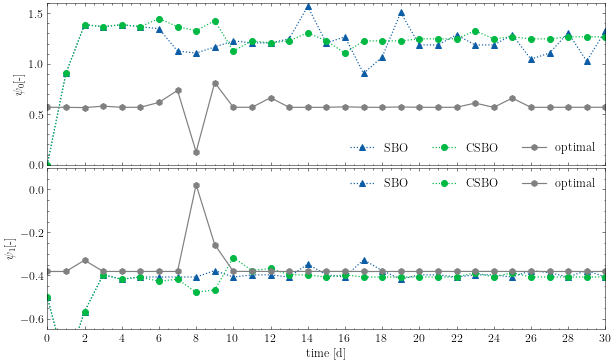

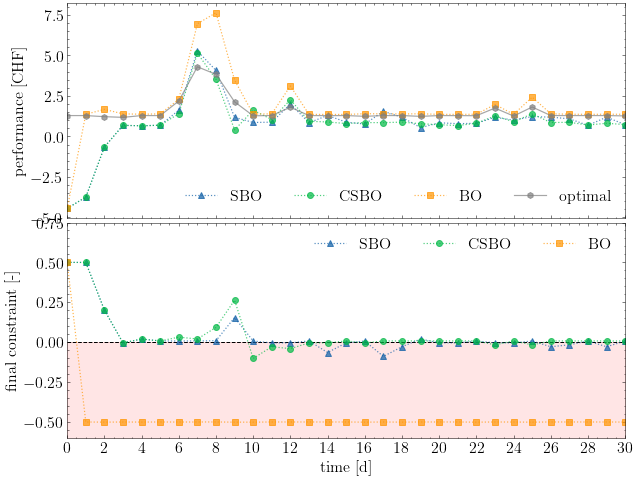

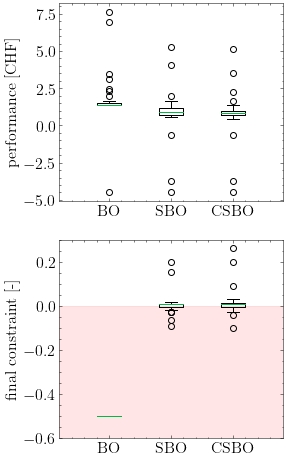

beta: 1 par_num 2


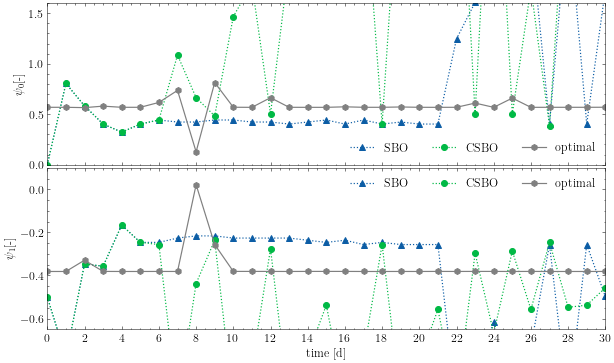

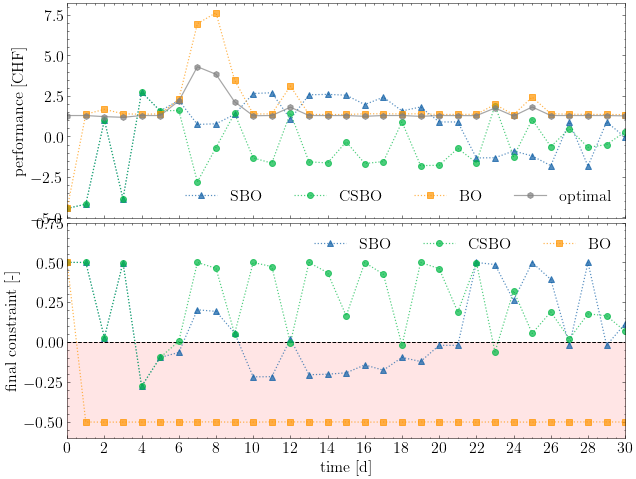

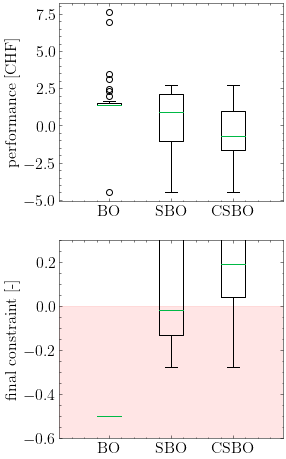

beta: 2 par_num 2


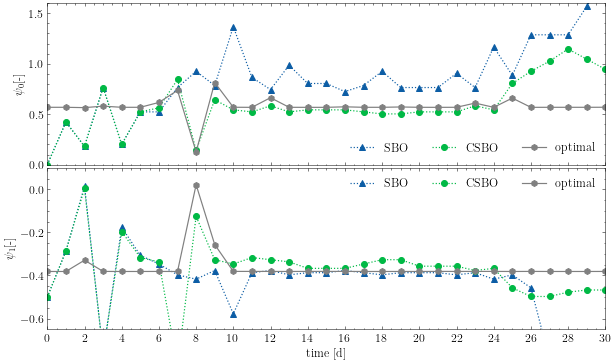

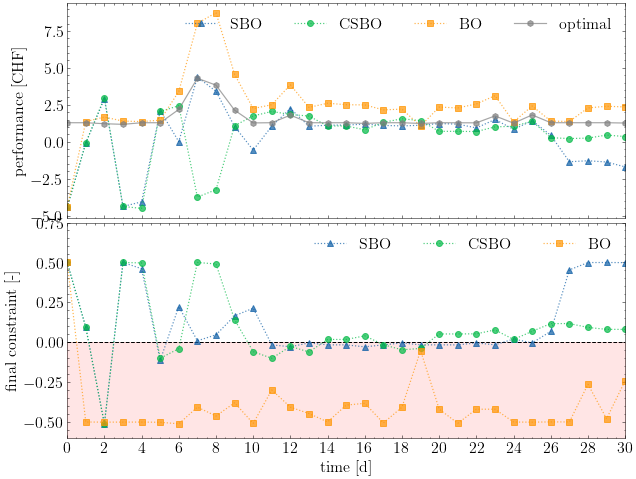

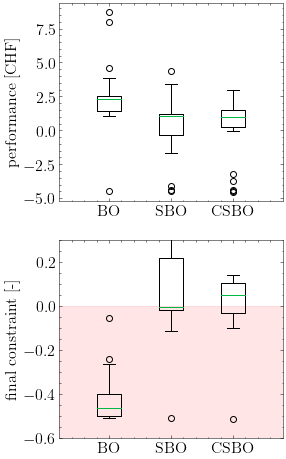

2
1
1
0.5
1
1
2
2
0.5
2
1
0.5
1
1
1
0.5
True
['1', '1', '2', '1', '2', '1', '0.5', '1', '2', '0.5', '1', '1', '0.5', '1', '2', '0.5']
[1.0, 1.0, 2.0, 1.0, 2.0, 1.0, 0.5, 1.0, 2.0, 0.5, 1.0, 1.0, 0.5, 1.0, 2.0, 0.5]
True
beta: 0.5 par_num 4


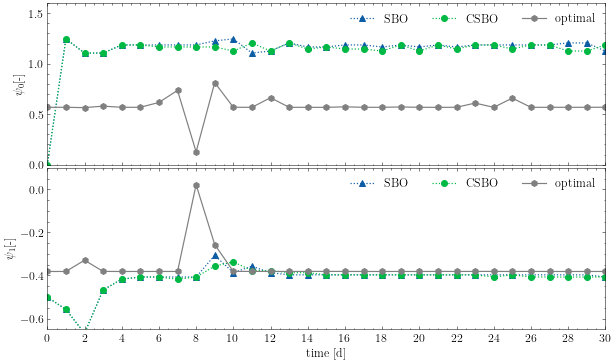

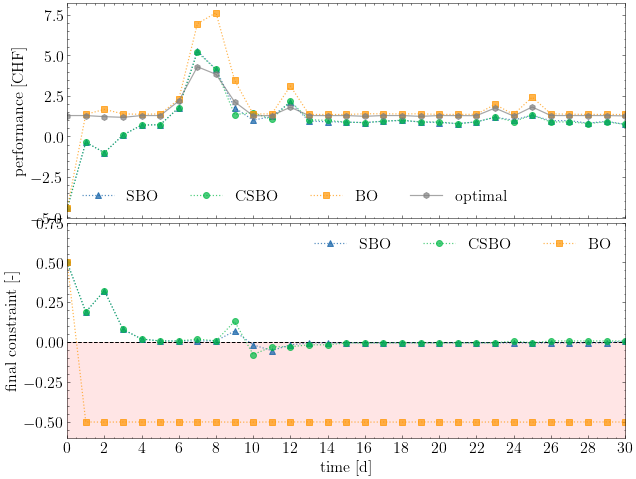

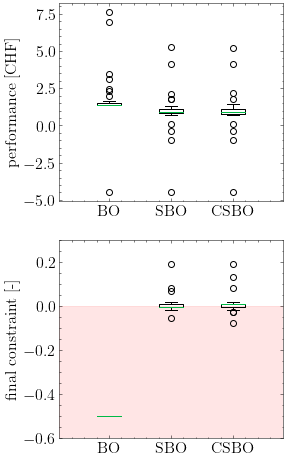

beta: 1 par_num 4


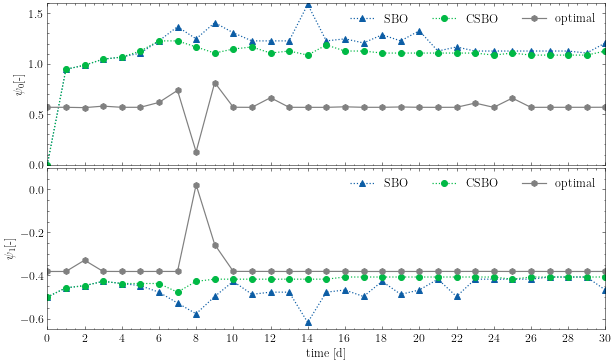

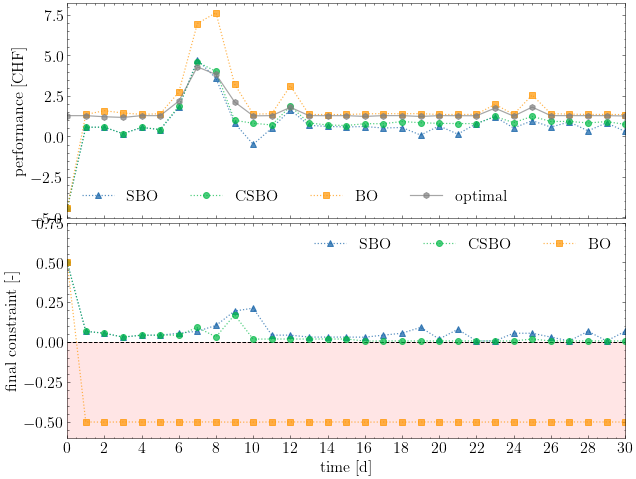

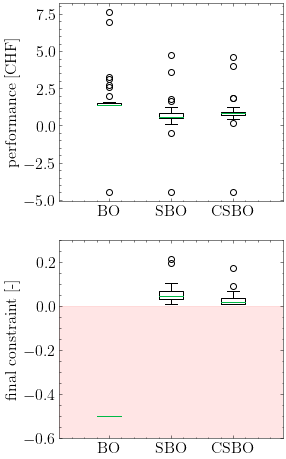

beta: 2 par_num 4


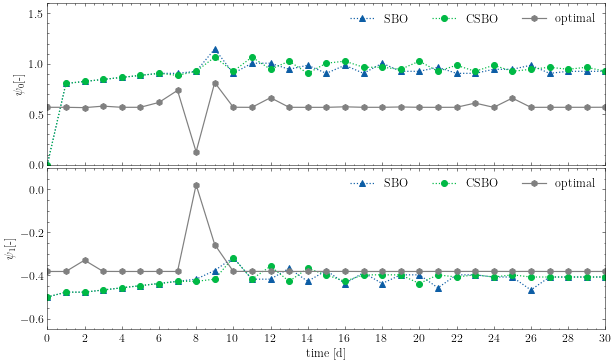

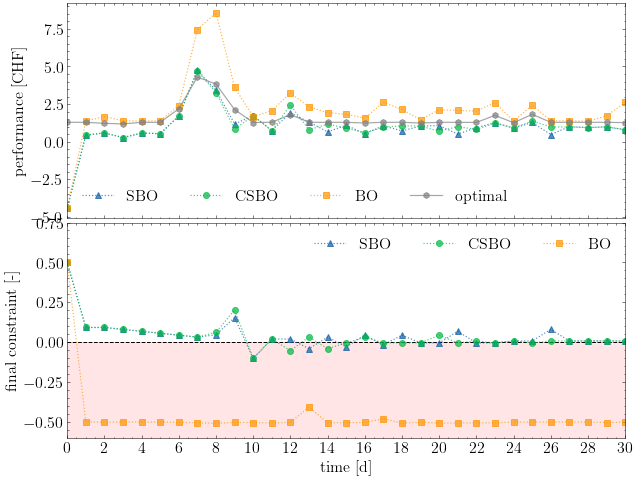

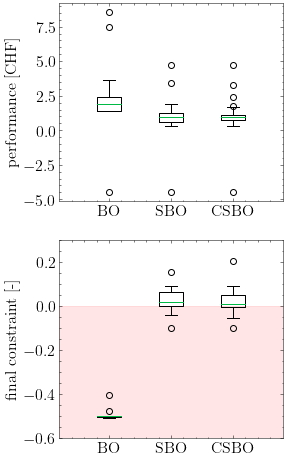

In [7]:
hp_list=[1,2,4]
tlim=30
fontsize=16
fontsize2=12
height2=6
height=8
x0=[0.,-0.5]
y0=[-4.44,0.5]
figfolder='Qfbounded'
for n in hp_list:
    import glob
    paths=glob.glob(f'sim_data_312_winter_rp0_qf_55_bounded/x_post_loglike{n}*')
    file_paths=[os.path.normpath(path).split(os.sep)[1] for path in paths] #get file names
    betas=[file_path.split('_')[3].strip('b') for file_path in file_paths] # get betas
    for i, beta in enumerate(betas):
        print(beta)
        if beta.startswith('0.'):
            betas[i]=float(beta.replace('0.','.'))
        elif beta.startswith('0'):
            betas[i]=float(beta.replace('0','.'))  
        else:
            betas[i]=float(beta) # convert to float and add . to 05

    optypes=[file_path.split('_')[4] for file_path in file_paths] # get optypes 
    dates=[file_path[-19:-4] for file_path in file_paths] # get betas

    par=[]
    for i,path in enumerate(paths):
        foo=np.delete(get_data(path),violations,axis=0)
        foo[0,:]=x0
        par.append(foo)
#     par=np.delete(par,violations)
    par_df=pd.DataFrame({'optype':optypes,'beta':betas,'par':par,'date':dates})
    par_df=par_df.set_index(['beta','optype']).sort_index()
    print(np.any(par_df.index.duplicated()))
    par_df=par_df[~par_df.index.duplicated()]

    paths=glob.glob(f'sim_data_312_winter_rp0_qf_55_bounded/y_post_loglike{n}*')
    file_paths=[os.path.normpath(path).split(os.sep)[1] for path in paths] #get file names
    betas=[file_path.split('_')[3].strip('b') for file_path in file_paths] # get betas
    print(betas)
    for i, beta in enumerate(betas):
        if beta.startswith('0.'):
            betas[i]=float(beta.replace('0.','.'))
        elif beta.startswith('0'):
            betas[i]=float(beta.replace('0','.'))  
        else:
            betas[i]=float(beta) # convert to float and add . to 05

    optypes=[file_path.split('_')[4] for file_path in file_paths] # get optypes 
    dates=[file_path[-19:-4] for file_path in file_paths] # get betas
    print(betas)
    ct=10 #convergence time
    mae_=[]
    mae=[]
    cnst10=[]
    cnst0=[]
    cnst20=[]
    cnst15=[]
    cnst5=[]
    cts=[]
    cnst_hist=[]
    cnst_=[]
    sft_=[]
    cst_=[]
    for i,path in enumerate(paths):
        foo=np.delete(get_data(path),violations,axis=0)
        foo[0,:]=y0
        cst=foo
        cst_.append(cst)
        err=-rnd_opt_cst.flatten()[ct:len(cst)]-cst[ct:,0]
        mae_.append(np.abs(err))
        mae.append(np.abs(err).sum()/(len(cst)-ct))   
        cnst=get_data(path)[:,1]
#         sft=get_data(path)[:,2]        
        cnst_hist.append(np.histogram(cnst,bins=20,range=(-0.5,0)))
        cnst10.append((cnst<-2e-2).astype(int).sum())
        cnst[cnst>0]=0
        cnst_.append(-cnst*50)
#         sft[sft>0]=0
#         sft_.append(-sft*50)        


    eval_df=pd.DataFrame({'optype':optypes,'beta':betas,'cst_':cst_,'mae':mae,'mae_':mae_,'hst':cnst_hist,'date':dates,
                         'cnst10':cnst10,'cnst_':cnst_})
    eval_df=eval_df.set_index(['beta','optype']).sort_index()
    print(np.any(eval_df.index.duplicated()))
    eval_df=eval_df[~eval_df.index.duplicated()]
    betas_list=[0.5,1,2]
    for beta in betas_list:
        print('beta:',beta,'par_num',n)
        model_label=['SBO','CSBO','BO']
        marker=['^','o','s']
        #Parameter plot
        with plt.style.context('science'):
            plt.rcParams.update({'font.size': fontsize2})                        
            err=25e-2
            iterations=len(par_df.loc[(beta,'CSBO'),'par'][:,0])
            fig,ax=plt.subplots(2,sharex=True,figsize=(10,height2))
            for col,m in zip(model_label[:-1],marker[:-1]):
                ax[0].plot(range(iterations),par_df.loc[(beta,col),'par'][:,0],f':{m}',label=col,linewidth=1.2)
                ax[1].plot(range(iterations),par_df.loc[(beta,col),'par'][:,1],f':{m}',label=col,linewidth=1.2)
            ax[0].plot(range(iterations),rnd_opt_par[:iterations,0],'-h',label='optimal',linewidth=1.2,color='grey')
            ax[1].plot(range(iterations),rnd_opt_par[:iterations,1],'-h',label='optimal',linewidth=1.2,color='grey')
            ax[0].set_xticks(np.arange(0,iterations,2))
            ax[0].set_ylim([0,1.6])
            ax[1].set_ylim([-0.65,0.1])
            ax[0].set_ylabel(r'$\psi_0$[-]')
            ax[0].legend(ncol=3)    
            ax[1].set_ylabel(r'$\psi_1$[-]')
            ax[1].legend(ncol=3)

            plt.xlabel('time [d]')
            plt.xlim([0,tlim])
            plt.subplots_adjust(hspace=0.02)
            plt.savefig(f'{figfolder}/{n}_par_rp_b0_qs_32_qf_55_beta_{beta}.pdf')
            plt.show()
        # Performance and constraint plots    
        with plt.style.context('science'):
            err=25e-2
            plt.rcParams.update({'font.size': fontsize})            
            iterations=len(par_df.loc[(beta,'CSBO'),'par'][:,0])
            fig,ax=plt.subplots(2,sharex=True,figsize=(10,height))
            for col,m in zip(model_label,marker):
                ax[0].plot(range(iterations),eval_df.loc[(beta,col),'cst_'][:,0],f':{m}',label=col,linewidth=1.2,alpha=0.7)
                ax[1].plot(range(iterations),eval_df.loc[(beta,col),'cst_'][:,1],f':{m}',label=col,linewidth=1.2,alpha=0.7)

            ax[0].plot(range(iterations),-rnd_opt_cst[:iterations,0],'-h',label='optimal',linewidth=1.2,color='grey',alpha=0.7)
            ax[1].hlines(0,0,iterations,'k',linestyles='--')
            ax[1].fill_between(range(iterations),y1=0,y2=-1,color='red',alpha=0.1)


        #     ax[1].plot(range(iterations),rnd_opt_cst[:iterations,1],':h',label='Optimal',linewidth=1.2,color='grey')
            ax[0].set_xticks(np.arange(0,iterations,2))
            ax[0].set_ylabel(r'performance [CHF]')
            ax[0].legend(ncol=4)    
#             ax[0].set_ylim([-5,6.2])            
            ax[1].set_ylim([-0.6,0.75])

            ax[1].set_ylabel(r'final constraint [-]')
            ax[1].legend(ncol=3)

            plt.xlabel('time [d]')
            plt.xlim([0,tlim])
            plt.subplots_adjust(hspace=0.02)
            plt.savefig(f'{figfolder}/{n}_prf_rp_b0_qs_32_qf_55_beta_{beta}.pdf')
            plt.show()
        model_label=['BO','SBO', 'CSBO']
        model_names=[ 'BO','SBO', 'CSBO']
        # MAE and violation boxplots
        with plt.style.context('science'):
            plt.rcParams.update({'font.size': fontsize})            
            fig,ax=plt.subplots(2,1,figsize=(4,height))
            for i,col in enumerate(model_label): 
                ax[0].boxplot(eval_df.loc[(beta,col)].cst_[:,0],showfliers=True,labels=[model_names[i]],positions=[i/4],widths=0.1)
                ax[0].set_ylabel(r'performance [CHF]')
                ax[0].set_xlim([-0.2,0.7]) 
                ax[1].boxplot(eval_df.loc[(beta,col)].cst_[:,1],showfliers=True,labels=[model_names[i]],positions=[i/4],widths=0.1)

                ax[1].set_ylabel(r'final constraint [-]')
                ax[1].set_xlim([-0.2,0.7]) 
                ax[1].set_ylim([-0.6,0.3])                 
#                 ax[2].boxplot(eval_df.loc[(beta,col)].cst_[:,2],showfliers=True,labels=[model_names[i]],positions=[i/4],widths=0.1)
#                 ax[2].set_ylabel(r'safety constraint [-]')     
#                 ax[2].set_xlim([-0.2,0.7]) 
#                 ax[2].set_ylim([-0.05,0.25])                  
#                 plt.ylim([-0.001,None])
    #             plt.yscale('log')
            #     plt.ylabel(r'$\textrm{R}^2$')
    #         plt.locator_params(axis="y", nbins=5) 
    #         plt.margins(tight=True)  
        #     plt.legend(['beta'])
            ax[1].fill_between(np.arange(-1,2),y1=0,y2=-2,color='red',alpha=0.1)
#             ax[2].fill_between(np.arange(-1,2),y1=0,y2=-2,color='red',alpha=0.1)            
            plt.savefig(f'{figfolder}/{n}_mae_qs_qf_boxplot_beta_{beta}.pdf')
            plt.show()

In [21]:
hp_list=[1,2,3,4]
tlim=50
height=8
height2=6

import glob
paths=glob.glob(f'sim_data_312_winter_rp0_qf_55_bounded/x_post_*')
file_paths=[os.path.normpath(path).split(os.sep)[1] for path in paths] #get file names
betas=[file_path.split('_')[3].strip('b') for file_path in file_paths] # get betas
for i, beta in enumerate(betas):
    if beta.startswith('0.'):
        betas[i]=float(beta.replace('0.','.'))
    elif beta.startswith('0'):
        betas[i]=float(beta.replace('0','.'))       
    else:
        betas[i]=float(beta) # convert to float and add . to 05

optypes=[file_path.split('_')[4] for file_path in file_paths] # get optypes 
dates=[file_path[-19:-4] for file_path in file_paths] # get betas

par=[]
for i,path in enumerate(paths):
    par.append(get_data(path))



par_df=pd.DataFrame({'optype':optypes,'beta':betas,'par':par,'date':dates})
par_df=par_df.set_index(['beta','optype']).sort_index()
print(np.any(par_df.index.duplicated()))
# par_df=par_df[~par_df.index.duplicated()]

paths=glob.glob(f'sim_data_312_winter_rp0_qf_55_bounded//y_post*')
file_paths=[os.path.normpath(path).split(os.sep)[1] for path in paths] #get file names
betas=[file_path.split('_')[3].strip('b') for file_path in file_paths] # get betas
hpar=[file_path.split('_')[2].strip('b') for file_path in file_paths] # get hp names
for i, beta in enumerate(betas):
    if beta.startswith('0.'):
        betas[i]=float(beta.replace('0.','.'))
    elif beta.startswith('0'):
        betas[i]=float(beta.replace('0','.'))        
    else:
        betas[i]=float(beta) # convert to float and add . to 05

optypes=[file_path.split('_')[4] for file_path in file_paths] # get optypes 
dates=[file_path[-19:-4] for file_path in file_paths] # get betas
ct=10 #convergence time
mae_=[]
mae=[]
cnst10=[]
cnstavg=[]
sftavg=[]
cts=[]
cnst_hist=[]
cnst_=[]
sft_=[]
cst_=[]
for i,path in enumerate(paths):
    cst=get_data(path)[:]
    cst_.append(cst)
    err=-rnd_opt_cst.flatten()[ct:len(cst)]-cst[ct:,0]
    mae_.append(np.abs(err))
    mae.append(np.abs(err).mean())
    cnst=get_data(path)[:,1]
#     sft=get_data(path)[:,2]        
    cnst_hist.append(np.histogram(cnst,bins=20,range=(-0.5,0)))
    cnst10.append((cnst<-2e-2).astype(int).sum())
    cnst[cnst>0]=0
    cnst_.append(-cnst*50)
    cnstavg.append(cnst.mean()*50)
#     sft[sft>0]=0
#     sft_.append(-sft*50) 
#     sftavg.append(sft.mean()*50)


eval_df=pd.DataFrame({'optype':optypes,'beta':betas,'mae':mae,'cnst':cnstavg,'cst_':cst_,'mae_':mae_,'hst':cnst_hist,'date':dates,
                     'cnst10':cnst10,'cnst_':cnst_,'hpar':hpar})
eval_df=eval_df.set_index(['beta','optype']).sort_index()
print(np.any(eval_df.index.duplicated()))
# eval_df=eval_df[~eval_df.index.duplicated()]


True
True


In [22]:
eval_df.sort_values('mae')

mae       cnst  \
beta optype                        
1.0  BO      0.180114 -24.243412   
     BO      0.180114 -24.243412   
0.5  BO      0.182324 -24.245513   
1.0  BO      0.184724 -24.249040   
0.5  BO      0.185604 -24.251816   
     BO      0.185604 -24.251816   
1.0  BO      0.195688 -24.247003   
0.5  SBO     0.198149  -2.832973   
2.0  CSBO    0.202408  -0.370692   
0.5  BO      0.219107 -24.275152   
     CSBO    0.261073  -2.339255   
     CSBO    0.276547  -2.317889   
1.0  CSBO    0.306588  -1.281089   
0.5  SBO     0.324464  -2.970142   
     SBO     0.365511  -3.450794   
     SBO     0.369014  -0.275010   
     SBO     0.370580  -1.002147   
     CSBO    0.382075  -0.353503   
2.0  CSBO    0.402972  -0.373536   
     SBO     0.410809  -0.338098   
1.0  CSBO    0.419767   0.000000   
0.5  CSBO    0.429944  -3.179986   
     CSBO    0.443199  -0.887240   
1.0  CSBO    0.448602   0.000000   
2.0  CSBO    0.528581  -1.628599   
1.0  CSBO    0.535179  -2.371607   
     SBO     0.574269  -3.776626   
2.0  SBO     0.638780  -0.094598   
     BO      0.644572 -24.187453   
1.0  CSBO    0.707170  -2.646651   
     BO      0.709489 -24.249174   
     SBO     0.747801   0.000000   
2.0  CSBO    0.751564  -0.141605   
     SBO     0.804673  -1.358273   
1.0  SBO     0.819593  -4.656280   
     SBO     0.831486  -3.960733   
     SBO     0.857384   0.000000   
2.0  BO      0.917743 -14.160758   
     BO      0.944924 -20.881962   
     BO      0.944924 -20.881962   
1.0  BO      1.034369 -13.623570   
2.0  SBO     1.078418  -0.094598   
0.5  BO      1.206930 -18.418913   
1.0  SBO     1.430147  -3.720235   
0.5  SBOb    1.776009  -1.465413   
     SBOb    1.877512  -1.445882   
1.0  CSBO    1.969347  -1.093796   
0.5  SBOb    2.046590  -0.411061   
     SBOb    2.210501  -0.741779   
1.0  SBOb    2.338827   0.000000   
     SBOb    2.355109   0.000000   
     SBOb    2.409476   0.000000   
0.5  SBOb    2.473278  -1.156107   
1.0  SBOb    2.492816  -1.165058   
2.0  SBOb    2.602289   0.000000   
1.0  SBOb    2.717514  -0.234320   
2.0  SBOb    2.776515  -1.044284   
     SBOb    2.927327  -0.066642   
1.0  SBOb    3.055020  -0.234320   
2.0  SBOb    3.144194  -0.664984   

                                                          cst_  \
beta optype                                                      
1.0  BO      [[-1.9736434976900465, 0.4993125711164251], [1...   
     BO      [[-1.9736434976900465, 0.4993125711164251], [1...   
0.5  BO      [[-1.9735877821934782, 0.4993125231226668], [1...   
1.0  BO      [[-1.973584136364111, 0.4993125182814089], [1....   
0.5  BO      [[-1.9736492707842777, 0.49931257505205623], [...   
     BO      [[-1.9736492707842777, 0.49931257505205623], [...   
1.0  BO      [[-1.9802349354189026, 0.4993125182814089], [1...   
0.5  SBO     [[2.5910461944909997, -0.2014068682666192], [-...   
2.0  CSBO    [[1.6335168388999066, -0.04131834333577245], [...   
0.5  BO      [[-1.9802783604553191, 0.49931257505205623], [...   
     CSBO    [[2.5910461944909997, -0.2014068682666192], [-...   
     CSBO    [[2.5910461944909997, -0.2014068682666192], [-...   
1.0  CSBO    [[-0.7790951699639213, 0.17068087278067806], [...   
0.5  SBO     [[2.5910461944909997, -0.2014068682666192], [-...   
     SBO     [[2.5910461944909997, -0.2014068682666192], [-...   
     SBO     [[-0.11306178965601532, 0.16469013549961148], ...   
     SBO     [[2.5868671375948953, -0.3237787480859998], [-...   
     CSBO    [[-0.11306178965601532, 0.16469013549961148], ...   
2.0  CSBO    [[0.323935517603247, 0.10379974254031296], [0....   
     SBO     [[0.323935517603247, 0.10379974254031296], [0....   
1.0  CSBO    [[0.5192571289292536, 0.07979311185012435], [0...   
0.5  CSBO    [[2.5910461944909997, -0.2014068682666192], [-...   
     CSBO    [[2.5868671375948953, -0.3237787480859998], [-...   
1.0  CSBO    [[0.5192571289292536, 0.07979311185012435], [0...   
2.0  CSBO    [[-0.5468425284998821, 0.17474375454254187], [...   
1.0

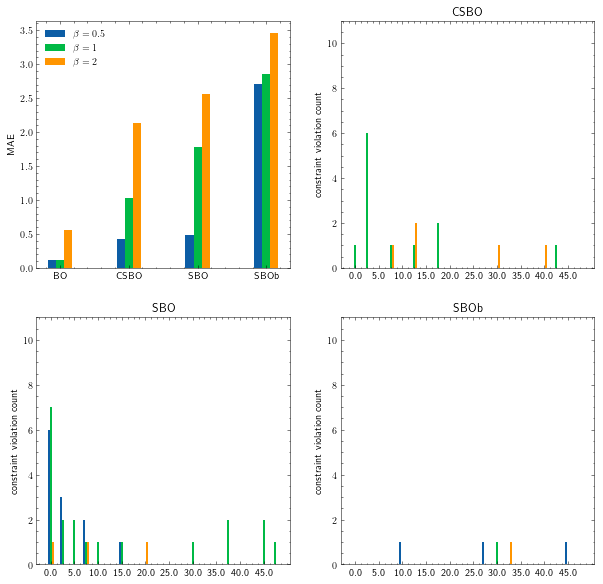

In [149]:
with plt.style.context('science'):
    x = np.arange(len(eval_df.index.levels[1]))  # the label locations
    width = 0.35  # the width of the bars

    fig, axes = plt.subplots(2,2,figsize=(10,10))
    rects1 = axes[0,0].bar(x - width/3, eval_df.loc[0.5].mae, width/3, label=r'$\beta=0.5$')
    rects2 = axes[0,0].bar(x , eval_df.loc[1].mae, width/3, label=r'$\beta=1$',tick_label=eval_df.index.levels[1])
    rects3 = axes[0,0].bar(x + width/3, eval_df.loc[2].mae, width/3, label=r'$\beta=2$')
    axes[0,0].set_ylabel('MAE')
    axes[0,0].legend()
    n_bins=20
    x = np.arange(len(eval_df.loc[(0.5,'CSBO')].hst[1][-n_bins:]))  # the label locations
    for i,ax in enumerate(axes.flatten()[1:]):
        width=0.5
        op=eval_df.index.levels[1][i+1]
        rects1 = ax.bar(x - width/3, eval_df.loc[(0.5,op)].hst[0][-n_bins:][::-1], width/3, label=r'$\beta=0.5$')
        rects2 = ax.bar(x , eval_df.loc[(1,op)].hst[0][-n_bins:][::-1], width/3, label=r'$\beta=1$',
                        tick_label=(np.abs(eval_df.loc[(0.5,'CSBO')].hst[1][-n_bins:])*100).round(1)[::-1])
        rects3 = ax.bar(x + width/3, eval_df.loc[(2,op)].hst[0][-n_bins:][::-1], width/3, label=r'$\beta=2$')
        ax.set_xticks(np.arange(0,n_bins,2))
        
        # Add some text for labels, title and custom x-axis tick labels, etc.
        ax.set_ylabel('constraint violation count')
        ax.set_ylim([0,11])
        ax.set_title(op)
    # ax.bar_label(rects1, padding=3)
    # ax.bar_label(rects2, padding=3)
    # ax.bar_label(rects3, padding=3)

#     fig.tight_layout()
#     axes[1,1].set_xlim([10,30])
# plt.savefig('../fig_scripts/eval_mae_cnstviol_rp_qf55_loglike3_.png')
plt.show()

In [11]:
hp_list=[1,2,3,4]
tlim=50
height=8
height2=6

import glob
paths=glob.glob(f'sim_data_312_winter_rp0_qf_55_qs_32_model200C/x_post_*')
file_paths=[os.path.normpath(path).split(os.sep)[1] for path in paths] #get file names
betas=[file_path.split('_')[3].strip('b') for file_path in file_paths] # get betas
for i, beta in enumerate(betas):
    if beta.startswith('0.'):
        betas[i]=float(beta.replace('0.','.'))
    elif beta.startswith('0'):
        betas[i]=float(beta.replace('0','.'))       
    else:
        betas[i]=float(beta) # convert to float and add . to 05

optypes=[file_path.split('_')[4] for file_path in file_paths] # get optypes 
dates=[file_path[-19:-4] for file_path in file_paths] # get betas

par=[]
for i,path in enumerate(paths):
    par.append(get_data(path))



par_df=pd.DataFrame({'optype':optypes,'beta':betas,'par':par,'date':dates})
par_df=par_df.set_index(['beta','optype']).sort_index()
print(np.any(par_df.index.duplicated()))
# par_df=par_df[~par_df.index.duplicated()]

paths=glob.glob(f'sim_data_312_winter_rp0_qf_55_qs_32_model200C/y_post*')
file_paths=[os.path.normpath(path).split(os.sep)[1] for path in paths] #get file names
betas=[file_path.split('_')[3].strip('b') for file_path in file_paths] # get betas
hpar=[file_path.split('_')[2].strip('b') for file_path in file_paths] # get hp names
for i, beta in enumerate(betas):
    if beta.startswith('0.'):
        betas[i]=float(beta.replace('0.','.'))
    elif beta.startswith('0'):
        betas[i]=float(beta.replace('0','.'))        
    else:
        betas[i]=float(beta) # convert to float and add . to 05

optypes=[file_path.split('_')[4] for file_path in file_paths] # get optypes 
dates=[file_path[-19:-4] for file_path in file_paths] # get betas
ct=10 #convergence time
mae_=[]
mae=[]
cnst10=[]
cnstavg=[]
sftavg=[]
cts=[]
cnst_hist=[]
cnst_=[]
sft_=[]
cst_=[]
for i,path in enumerate(paths):
    cst=get_data(path)[:]
    cst_.append(cst)
    err=-rnd_opt_cst.flatten()[ct:len(cst)]-cst[ct:,0]
    mae_.append(np.abs(err))
    mae.append(np.abs(err).mean())
    cnst=get_data(path)[:,1]
    sft=get_data(path)[:,2]        
    cnst_hist.append(np.histogram(cnst,bins=20,range=(-0.5,0)))
    cnst10.append((cnst<-2e-2).astype(int).sum())
    cnst[cnst>0]=0
    cnst_.append(-cnst*50)
    cnstavg.append(cnst.mean()*50)
    sft[sft>0]=0
    sft_.append(-sft*50) 
    sftavg.append(sft.mean()*50)


eval_df=pd.DataFrame({'optype':optypes,'beta':betas,'mae':mae,'cnst':cnstavg,'sft':sftavg,'cst_':cst_,'mae_':mae_,'hst':cnst_hist,'date':dates,
                     'cnst10':cnst10,'cnst_':cnst_,'sft_':sft_,'hpar':hpar})
eval_df=eval_df.set_index(['beta','optype']).sort_index()
print(np.any(eval_df.index.duplicated()))
# eval_df=eval_df[~eval_df.index.duplicated()]


True
True


In [12]:
eval_df.sort_values('mae')

mae       cnst       sft  \
beta optype                                  
0.5  CSBO    1.187844  -4.479766 -0.310332   
     CSBO    1.243992  -2.634204 -0.722184   
     SBO     1.261081  -2.200790 -1.482173   
     BO      1.319510 -24.637897 -2.076554   
1.0  BO      1.320256 -24.638584 -2.076452   
2.0  BO      1.323436 -24.641997 -2.076931   
     BO      1.323436 -24.641997 -2.076931   
0.5  BO      1.327804 -24.645509 -2.076490   
     BO      1.327804 -24.645509 -2.076490   
2.0  BO      1.331076 -24.647013 -2.078681   
1.0  BO      1.332501 -24.647803 -2.077675   
     BO      1.332501 -24.647803 -2.077675   
0.5  CSBO    1.404208  -1.884069 -0.219797   
2.0  CSBO    1.564329  -1.595435 -0.162309   
0.5  CSBO    1.966138  -1.605317 -0.053429   
1.0  SBO     2.042461   0.000000 -1.720874   
0.5  SBO     2.047039  -4.211096 -0.510679   
1.0  CSBO    2.306433  -2.428499 -0.140789   
     CSBO    2.506170  -1.725999 -0.101180   
2.0  CSBO    2.533681  -1.335152 -0.465660   
0.5  SBO     2.551170  -4.106579 -0.389510   
     SBO     2.702930  -4.376550 -0.362096   
1.0  CSBO    2.744553  -1.577699 -0.200726   
     CSBO    2.835697  -0.824267 -0.560611   
2.0  SBO     3.168320  -1.548263 -0.042361   
     BO      3.255580 -18.361083 -1.880532   
1.0  SBO     3.305515  -4.145575 -0.295533   
0.5  BO      3.378031 -23.871566 -2.032731   
1.0  BO      3.426177 -23.615405 -2.072579   
2.0  SBO     4.237224   0.000000 -1.111212   
     CSBO    4.336890   0.000000 -1.046880   
     SBO     4.770820  -1.486206 -0.037639   
1.0  SBO     4.972254  -1.908676 -0.045560   
     SBO     4.998691  -1.990155 -0.045560   
2.0  SBO     5.194252  -1.720212 -0.062355   
     CSBO    5.712941  -0.006558  0.000000   
0.5  SBOb    7.987912  -2.810565 -0.559835   
     SBOb    8.065592  -2.421133 -0.755474   
     SBOb    8.089516  -1.735055 -0.715856   
1.0  SBOb    8.320870  -1.707040 -0.563846   
     SBOb    8.770029  -0.995600 -0.436600   
2.0  SBOb    9.029716  -0.906177 -0.242068   
     SBOb    9.046012  -0.650750 -0.278999   
1.0  SBOb    9.046513  -1.955076 -0.426908   
2.0  SBOb    9.144916  -0.621773 -0.145865   
     SBOb    9.258017  -0.818774 -0.222919   
1.0  SBOb    9.276140  -1.118336 -0.418289   
0.5  SBOb    9.297633  -1.845764 -0.331911   

                                                          cst_  \
beta optype                                                      
0.5  CSBO    [[-8.697836647857713, 0.49973139258949517, 0.9...   
     CSBO    [[-8.417458031695459, 0.4993756660582014, 0.95...   
     SBO     [[-8.417458031695459, 0.4993756660582014, 0.95...   
     BO      [[-3.779149180177212, 0.4990639417087141, -0.0...   
1.0  BO      [[-3.779149180177212, 0.4990639417087141, -0.0...   
2.0  BO      [[-3.779149180177212, 0.4990639417087141, -0.0...   
     BO      [[-3.779149180177212, 0.4990639417087141, -0.0...   
0.5  BO      [[-3.779149180177212, 0.4990639417087141, -0.0...   
     BO      [[-3.779149180177212, 0.4990639417087141, -0.0...   
2.0  BO      [[-3.779149180177212, 0.4990639417087141, -0.0...   
1.0  BO      [[-3.779149180177212, 0.4990639417087141, -0.0...   
     BO      [[-3.779149180177212, 0.4990639417087141, -0.0...   
0.5  CSBO    [[-8.455195701380338, 0.4991381471600587, 0.95...   
2.0  CSBO    [[-8.453028868751465, 0.499642243195012, 0.959...   
0.5  CSBO    [[-8.455195701380338, 0.4991381471600587, 0.95...   
1.0  SBO     [[-8.451185573886864, 0.49962443634582937, 0.9...   
0.5  SBO     [[-8.455195701380338, 0.4991381471600587, 0.95...   
1.0  CSBO    [[-8.48222837620977, 0.4989833670143068, 0.958...   
     CSBO    [[-8.454319043609923, 0.49925223652077905, 0.9...   
2.0  CSBO    [[-8.453516827543266, 0.49929857461974225, 0.9...   
0.5  SBO     [[-8.455195701380338, 0.4991381471600587, 0.95...   
     SBO     [[-8.697836647857713, 0.49973139258949517, 0.9...   
1.0  CSBO    [[-8.454319043609923, 0.49925223652077905, 0.9...   
     CSBO    [[-8.451185573886864, 0.49962443634582937, 0.9...   
2

In [ ]:
with plt.style.context('science'):
    x = np.arange(len(eval_df.index.levels[1]))  # the label locations
    width = 0.35  # the width of the bars

    fig, axes = plt.subplots(1,3,figsize=(15,5))
    rects1 = axes[0].bar(x - width/3, eval_df.loc[0.5].mae, width/3, label=r'$\beta=0.5$')
    rects2 = axes[0].bar(x , eval_df.loc[1].mae, width/3, label=r'$\beta=1$',tick_label=eval_df.index.levels[1])
    rects3 = axes[0].bar(x + width/3, eval_df.loc[2].mae, width/3, label=r'$\beta=2$')
    axes[0].set_ylabel('MAE')
    axes[0].legend()
    axes[0].set_xlabel('optimizer')

    n_bins=10
    x = np.arange(len(eval_df.loc[(0.5,'CSBO')].hst[1][-n_bins:]))  # the label locations
    for i,ax in enumerate(axes.flatten()[1:]):
        width=0.5
        op=eval_df.index.levels[1][i+1]
        rects1 = ax.bar(x - width/3, eval_df.loc[(0.5,op)].hst[0][-n_bins:][::-1], width/3, label=r'$\beta=0.5$')
        rects2 = ax.bar(x , eval_df.loc[(1,op)].hst[0][-n_bins:][::-1], width/3, label=r'$\beta=1$',
                        tick_label=(np.abs(eval_df.loc[(0.5,'CSBO')].hst[1][-n_bins:])*100).round().astype(int)[::-1])
        rects3 = ax.bar(x + width/3, eval_df.loc[(2,op)].hst[0][-n_bins:][::-1], width/3, label=r'$\beta=2$')
        ax.set_xticks(np.arange(0,n_bins,2))
        
        # Add some text for labels, title and custom x-axis tick labels, etc.
        ax.set_ylabel('constraint violation count')
        ax.set_ylim([0,11])
        ax.set_title(op)
        ax.set_xlabel('bin [\%]')

    # ax.bar_label(rects1, padding=3)
    # ax.bar_label(rects2, padding=3)
    # ax.bar_label(rects3, padding=3)

#     fig.tight_layout()
#     axes[1,1].set_xlim([10,30])
# plt.savefig('../fig_scripts/eval_mae_cnstviol_rp_qf55_loglike3.png')
plt.show()

In [ ]:
with plt.style.context('science'):
    n_bins=20
    x = np.arange(len(eval_df.loc[(0.5,'CSBO')].hst[1][-n_bins:]))  # the label locations
    width = 0.35  # the width of the bars

    fig, axes = plt.subplots(3,figsize=(5,5))
    for i,ax in enumerate(axes.flatten()):
        op=eval_df.index.levels[1][i+1]
        rects1 = ax.bar(x - width/3, eval_df.loc[(0.5,op)].hst[0][-n_bins:], width/3, label=r'$\beta=0.5$')
        rects2 = ax.bar(x , eval_df.loc[(1,op)].hst[0][-n_bins:], width/3, label=r'$\beta=1$',
                        tick_label=(np.abs(eval_df.loc[(0.5,'CSBO')].hst[1][-n_bins:])*100).round(1))
        rects3 = ax.bar(x + width/3, eval_df.loc[(2,op)].hst[0][-n_bins:], width/3, label=r'$\beta=2$')

        # Add some text for labels, title and custom x-axis tick labels, etc.
        ax.set_ylabel('count')
        ax.set_title(op)
        # ax.set_xticks(eval_df.index.levels[1].values)
        ax.legend()

    # ax.bar_label(rects1, padding=3)
    # ax.bar_label(rects2, padding=3)
    # ax.bar_label(rects3, padding=3)

    fig.tight_layout()

plt.show()

In [129]:
eval_df.index.levels[1]

Index(['BO', 'CSBO', 'SBO', 'SBOb'], dtype='object', name='optype')

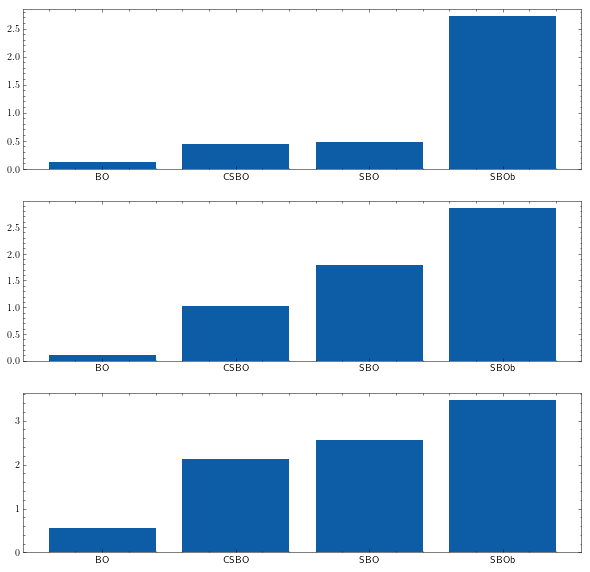

In [103]:
with plt.style.context('science'):
    fig,axes=plt.subplots(len(eval_df.index.levels[0]),figsize=(10,10))
    for i,ax in enumerate(axes.flatten()):
        df=eval_df.loc[eval_df.index.levels[0][i]]
        ax.bar(df.index,df.mae)

plt.show()

# GP evaluation

In [3]:
gps_b2=get_data('sim_data_312_winter_rp0_qf_55/CSBO_loglike3_b2__2022_03_08_0450')
gps_b05=get_data('sim_data_312_winter_rp0_qf_55/CSBO_loglike3_b05__2022_03_08_044')
bounds = [(0., 4.),(-1,1)]
parameter_set = safeopt.linearly_spaced_combinations(bounds, 100) 
optb2=safeopt.SafeOpt(gps_b2[1],parameter_set,fmin=0,num_contexts=1)
optb05=safeopt.SafeOpt(gps_b05[1],parameter_set,fmin=0,num_contexts=1)

This is local package in rbc-parameter-tuning
This is local package in rbc-parameter-tuning


3 3 1
context_fixed_inputs:  [(2, 0.0)]
3 3 1
context_fixed_inputs:  [(2, 1.0)]
3 3 1
context_fixed_inputs:  [(2, 0.0)]
3 3 1
context_fixed_inputs:  [(2, 1.0)]


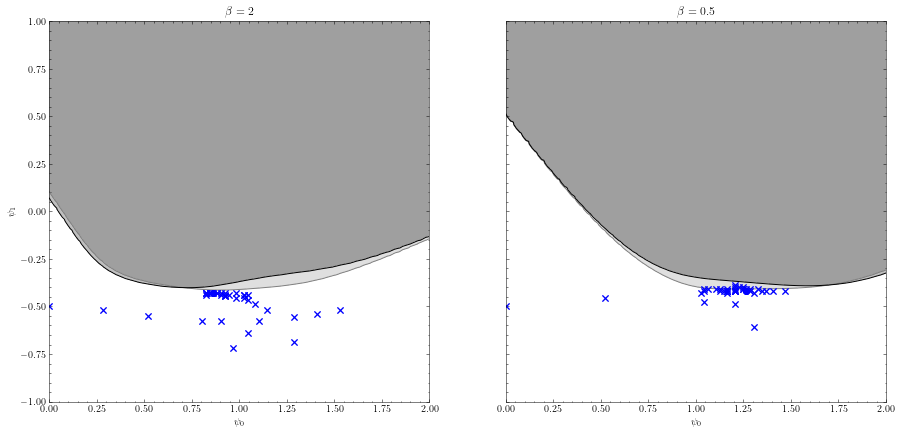

In [91]:
with plt.style.context('science'):
    fig,ax=plt.subplots(1,2,figsize=(15,7),sharey=True)
    optb2.context=[[0]]
    optb2.plot(100,levels=[-1,0,1],figure=fig,axis=ax[0], colors='grey',colorbar=False)
    optb2.context=[[1]]
    optb2.plot(100,levels=[-1,0,1],figure=fig,axis=ax[0],colors='black',colorbar=False)
    optb05.context=[[0]]
    optb05.plot(100,levels=[-1,0,1],figure=fig,axis=ax[1], colors='grey',colorbar=False)
    optb05.context=[[1]]
    optb05.plot(100,levels=[-1,0,1],figure=fig,axis=ax[1],colors='black',colorbar=False)
    ax[0].set_xlim([0,2])
    ax[1].set_xlim([0,2])
    ax[0].set_title(r'$\beta =2$')
    ax[1].set_title(r'$\beta =0.5$')
    ax[0].set_xlabel(r'$\psi_{0}$')
    ax[0].set_ylabel(r'$\psi_{1}$')    
    ax[1].set_xlabel(r'$\psi_{0}$')
    ax[1].set_title(r'$\beta =0.5$')
plt.savefig('../fig_scripts/qf_const_ctxt_loglike4.png')    
plt.show()

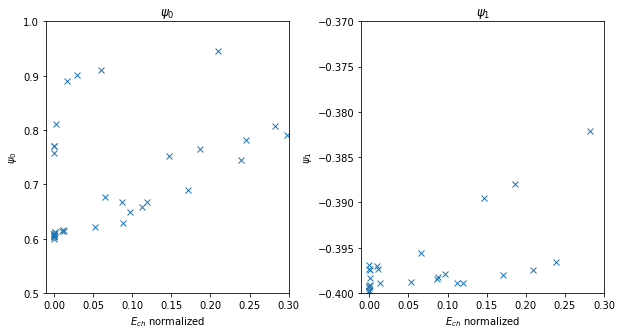

In [175]:
rnd_opt_cst=get_data('NL_opt/rnd_opt_cst_winter_3_1_2_2022_03_02_0252.npy')
rnd_opt_par=get_data('NL_opt/rnd_opt_par_winter_3_1_2_2022_03_02_0252.npy')
e_ch=get_data('sim_data_312_winter_rp0_qf_55/ech_winter_2022_03_08_0707.npy')
# rnd_opt_par=rnd_opt_par[~np.isnan(rnd_opt_par)]

fig,ax=plt.subplots(1,2,figsize=(10,5))
with plt.style.context('science'):
    ax[0].plot(e_ch[:len(rnd_opt_par)],rnd_opt_par[:,0],'x')
    ax[1].plot(e_ch[:len(rnd_opt_par)],rnd_opt_par[:,1],'x')
    ax[0].set_xlim([-0.01,0.3])
    ax[1].set_xlim([-0.01,0.3])
    ax[0].set_ylim([0.5,1])
    ax[1].set_ylim([-0.4,-0.37])
    ax[0].set_title(r'$\psi_0$')
    ax[0].set_xlabel(r'$E_{ch}$ normalized')
    ax[0].set_ylabel(r'$\psi_{0}$')    
    ax[1].set_xlabel(r'$E_{ch}$ normalized')
    ax[1].set_ylabel(r'$\psi_{1}$')
    ax[1].set_title(r'$\psi_1$')
plt.subplots_adjust(wspace=0.3)
plt.savefig('../fig_scripts/par_ech_corr_winter.png')

In [167]:
gps=get_data('sim_data_312_winter_rp0_qf_55/CSBO_loglike1_b05__2022_03_08_0421')
bounds = [(0., 4.),(-1,1)]
parameter_set = safeopt.linearly_spaced_combinations(bounds, 100) 
opt=safeopt.SafeOpt(gps,parameter_set,fmin=[-np.inf,0],num_contexts=1)


This is local package in rbc-parameter-tuning
